<font size="8"> **Calculating distance to nearest sea ice edge grid cell from all grid cells** </font>  
The sea ice edge was defined as the northernmost grid cells with a sea ice concentration of 10\% or more. The distance from each grid cell in the original data to the closest sea ice edge grid cell was calculated.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading modules

In [2]:
#Accessing model data
import cosima_cookbook as cc
#Dealing with data
import xarray as xr
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
#Collection of useful functions developed for this project
import UsefulFunctions as uf
#Useful package to deal with file paths
from glob import glob
#Parallelising work
from dask.distributed import Client

# Defining dictionary of useful variables
In this dictionary we will define a variables that will be used multiple times throughout this notebook to avoid repetition. It will mostly contain paths to folders where intermediate or final outputs will be stored.

In [1]:
varDict = {'var_mod': 'aice_m',
           'var_short_name': 'SIC',
           'var_long_name': 'sea ice concentration',
           'model': 'ACCESS-OM2-01',
           'exp': '01deg_jra55v140_iaf_cycle4',
           'exp_ext': '01deg_jra55v140_iaf_cycle4_jra55v150_extension',
           'freq': '1 monthly',
           'base_folder': '/g/data/v45/la6889/Chapter2_Crabeaters/SeaIce/Distance_Edge/'}

# Creating a session in the COSIMA cookbook

In [4]:
session = cc.database.create_session()

# Accessing ACCESS-OM2-01 data
First, we will start a cluster with multiple cores to make analysis faster. Remember the number of CPUs cannot exceed the CPUs you have access to.

In [5]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43703,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:43315,Total threads: 3
Dashboard: /proxy/37869/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:36507,


We will now access the model outputs. Here, we use monthly sea ice concentration outputs from ACCESS-OM2-01 fourth cycle for these calculations. The experiment name for the original 4th cycle is `01deg_jra55v140_iaf_cycle4` and it covers the period between January 1958 to December 2018. While, experiment `01deg_jra55v140_iaf_cycle4_jra55v150_extension` extends this fourth cycle to December 2022.
  
We are using cycle four because we are interested in examining the relationship between crabeater seal distribution and a variety of environmental variables, including biogeochemical factors (e.g., photosynthetic active radiation or PAR, and chlorophyll concentration). Only the fourth cycle has biogeochemical outputs available. See the [COSIMA website](https://cosima.org.au/index.php/2020/07/29/data-available-0-1-1958-2018-access-om2-iaf-run/) for more information.

In [8]:
#Loading data from fourth cycle (temporal range 1958 to 2018)
var_ice = uf.getACCESSdata_SO(varDict['var_mod'], '1978-01', '2019-01', 
                              freq = varDict['freq'], ses = session, 
                              exp = varDict['exp'], ice_data = True)
#Loading data from fourth cycle extension (2019 to 2022)
var_ice_ext = uf.getACCESSdata_SO(varDict['var_mod'], '2019-01', '2023-01', 
                              freq = varDict['freq'], ses = session, 
                              exp = varDict['exp_ext'], ice_data = True)

## Creating a single dataset for our study period
We need to merge both datasets so we can calculate the long-term presence of pack ice for our entire study period (1978 to 2022).

In [7]:
#Concatenating both data arrays into one
var_ice = xr.concat([var_ice, var_ice_ext], dim = 'time')
var_ice = uf.corrlong(var_ice)

#Removing duplicate variable
del var_ice_ext

# Finding sea ice edge
The sea ice edge is the defined as the northernmost areas where sea ice concentration (SIC) is under $10\%$. This is a multistep process:
1. Identify pixels where SIC is greater or equal to 0.1, and change value to 1,
2. Calculate cumulate sum along y axis,
3. Apply mask to remove original `NaN` values from cumulative sums.

This will result in pixels with the highest value along the y axis to be identified as the sea ice edge. 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


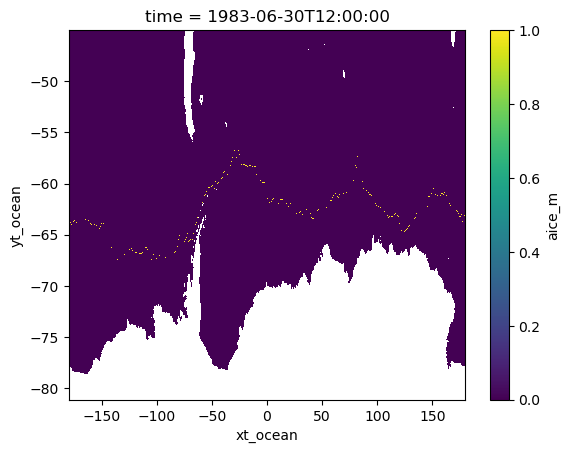

In [8]:
#Assign a value of 1 to any areas where SIC is at least 0.1
ice_10 = xr.where(var_ice >= 0.1, 1, np.nan)

#Adding all cells along y axis. Masking out NA values
ice_10 = ice_10.cumsum(dim = 'yt_ocean', skipna = True).where(~np.isnan(ice_10))

#Finding cells with highest value along y axis. This identifies the ice edge at each longitude.
ice_10 = xr.where(ice_10 == ice_10.max('yt_ocean'), 1, 0).where(~np.isnan(var_ice))

#Checking result for first time step
ice_10.isel(time = 0).plot()

## Checking results in relation to SIC data

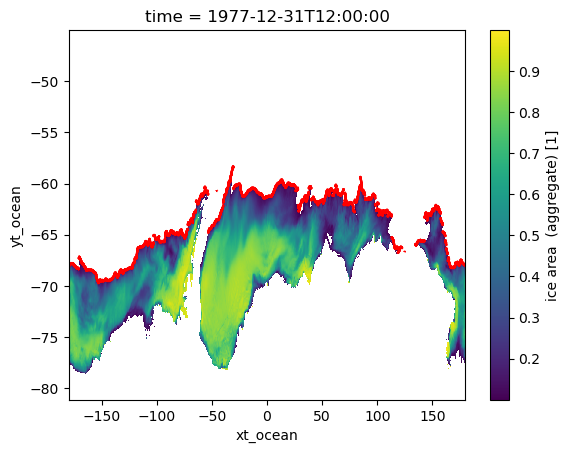

In [11]:
#Checking results for first time step
fig = plt.figure()
ax = fig.add_subplot(111)
var_ice.where(var_ice >= 0.1)[0].plot(ax = ax)
ice_10[0].plot.contour(ax = ax, colors = ['red'])

Above we plotted only pixels with SIC greater or equal to 0.1. The red line represents the sea ice edge we identified in the previous step. We can be satisfied that we identified the sea ice edge correctly.

# Getting coordinate pairs for each cell in the original grid
We will use the latitude and longitude values in our data to create coordinate pairs. We only need to get this information once if we are calculating distances from the same grid.  
  
We also need to transform coordinate pairs to radians as this is needed in the calculation of distances.

In [9]:
#Storing longitude and latitude values
x, y = np.meshgrid(np.deg2rad(var_ice.xt_ocean.values),
                   np.deg2rad(var_ice.yt_ocean.values))

#Changing shape so there are two values per row
grid_coords = np.vstack([y.flat, x.flat]).T

#Removing variables not needed
del x, y

# Calculating distance to closest sea ice edge cell
In the `UsefulFuctions` script there is a function called `nn_dist` that will apply the following steps to get the distance from each grid cell to the sea ice edge:
1. Get coordinate pairs of sea ice edge,
2. Use Nearest Neighbour algorithm to calculate distance to closest ice edge cell,
3. Transform distance from radians to kilometers,
4. Store result in a data array,
5. Save output to disk (optional).
  
We will apply this function to each time step in the data frame that contains our sea ice edge.

In [ ]:
#Applying function for each time step in the sea ice edge data array
for t in ice_10:
    da = uf.nn_dist(t, grid_coords,
                    folder_out = os.path.join(varDict['base_folder'], 'monthly'),
                    file_base = 'Distance_Sea_Ice_Edge')

## Loading all outputs saved to disk
We can load all results in a single dataset to check our results.

In [19]:
dist_ice_edge = xr.open_mfdataset(os.path.join(varDict['base_folder'], 'monthly', '*.nc')).dist_km
dist_ice_edge

<xarray.DataArray 'dist_km' (time: 493, yt_ocean: 740, xt_ocean: 3600)>
dask.array<concatenate, shape=(493, 740, 3600), dtype=float64, chunksize=(1, 740, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1977-12-31T12:00:00 ... 2018-12-31T12:00:00
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95

## Plotting results
We will check the first three time steps in our data array.

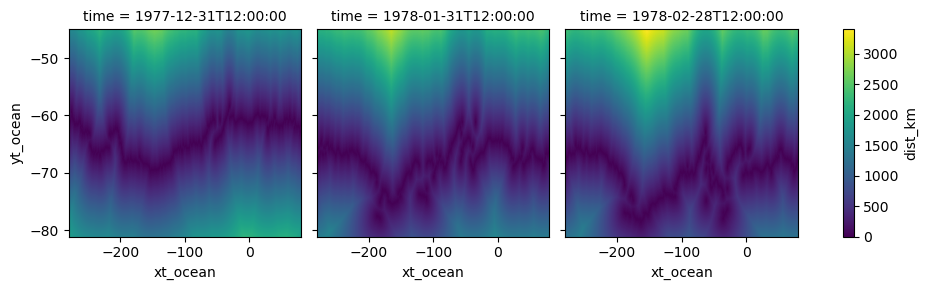

In [18]:
dist_ice_edge.isel(time = slice(0, 3)).plot(col = 'time')

These results make sense as we expect the sea ice to retreat during summer months (December to February). We can overlay the sea ice edge on the distance calculations to visually inspect the accuracy of our calculations.

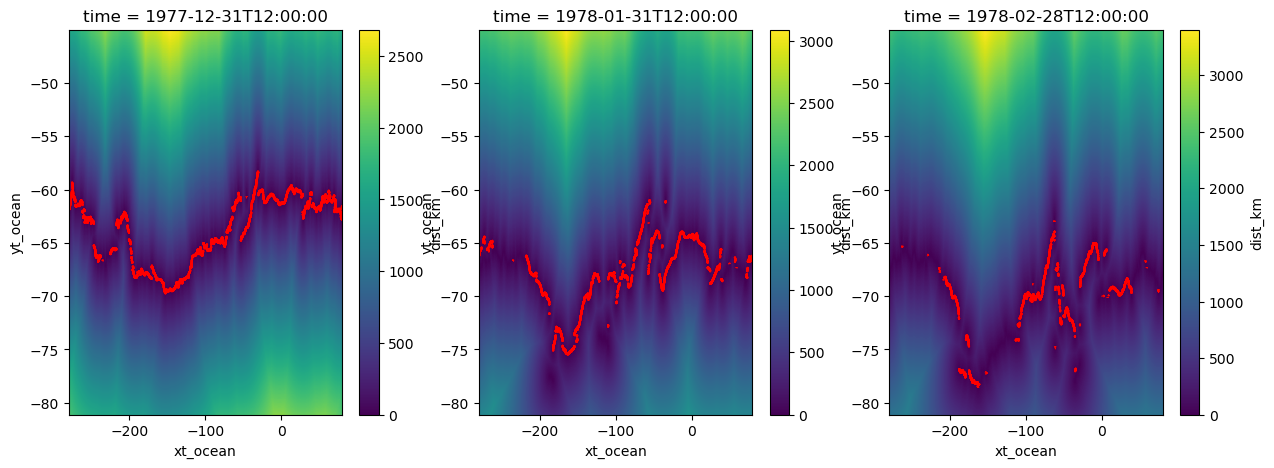

In [30]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

for i in range(0, 3):
    dist_ice_edge.isel(time = i).plot(ax = axs[i])
    ice_10.isel(time = i).plot.contour(ax = axs[i], colors = ['red'])

## Saving results as tiff

In [32]:
#Adding CRS (WGS84)
dist_ice_edge.rio.write_crs('epsg:4326', inplace = True)
#Changing latitude and longitude names
dist_ice_edge = dist_ice_edge.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
dist_ice_edge

<xarray.DataArray 'dist_km' (time: 541, y: 740, x: 3600)>
dask.array<concatenate, shape=(541, 740, 3600), dtype=float64, chunksize=(1, 740, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1977-12-31T12:00:00 ... 2022-12-31T12:...
  * y            (y) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
  * x            (x) float64 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
    spatial_ref  int64 0
Attributes:
    units:      km
    long_name:  distance to nearest neighbour

In [34]:
for i, t in enumerate(dist_ice_edge.time):
    ds_t = dist_ice_edge.sel(time = t)
    name_out = list_file[i].replace('monthly', 'Rasters_tiff').replace('.nc', '.tif')
    ds_t.rio.to_raster(name_out)